<a href="https://colab.research.google.com/github/IvanLopesGit/birdsongsdetection/blob/main/Bird_Sound_Detection_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
!pip install tensorflow
!pip install hmmlearn
!pip install python_speech_features
!pip install git+https://github.com/DmitryUlyanov/Multicore-TSNE.git

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from hmmlearn import hmm
from python_speech_features import logfbank, delta

## Google Drive Access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Gerando os Espectogramas com base no áudio do canto dos pássaros.

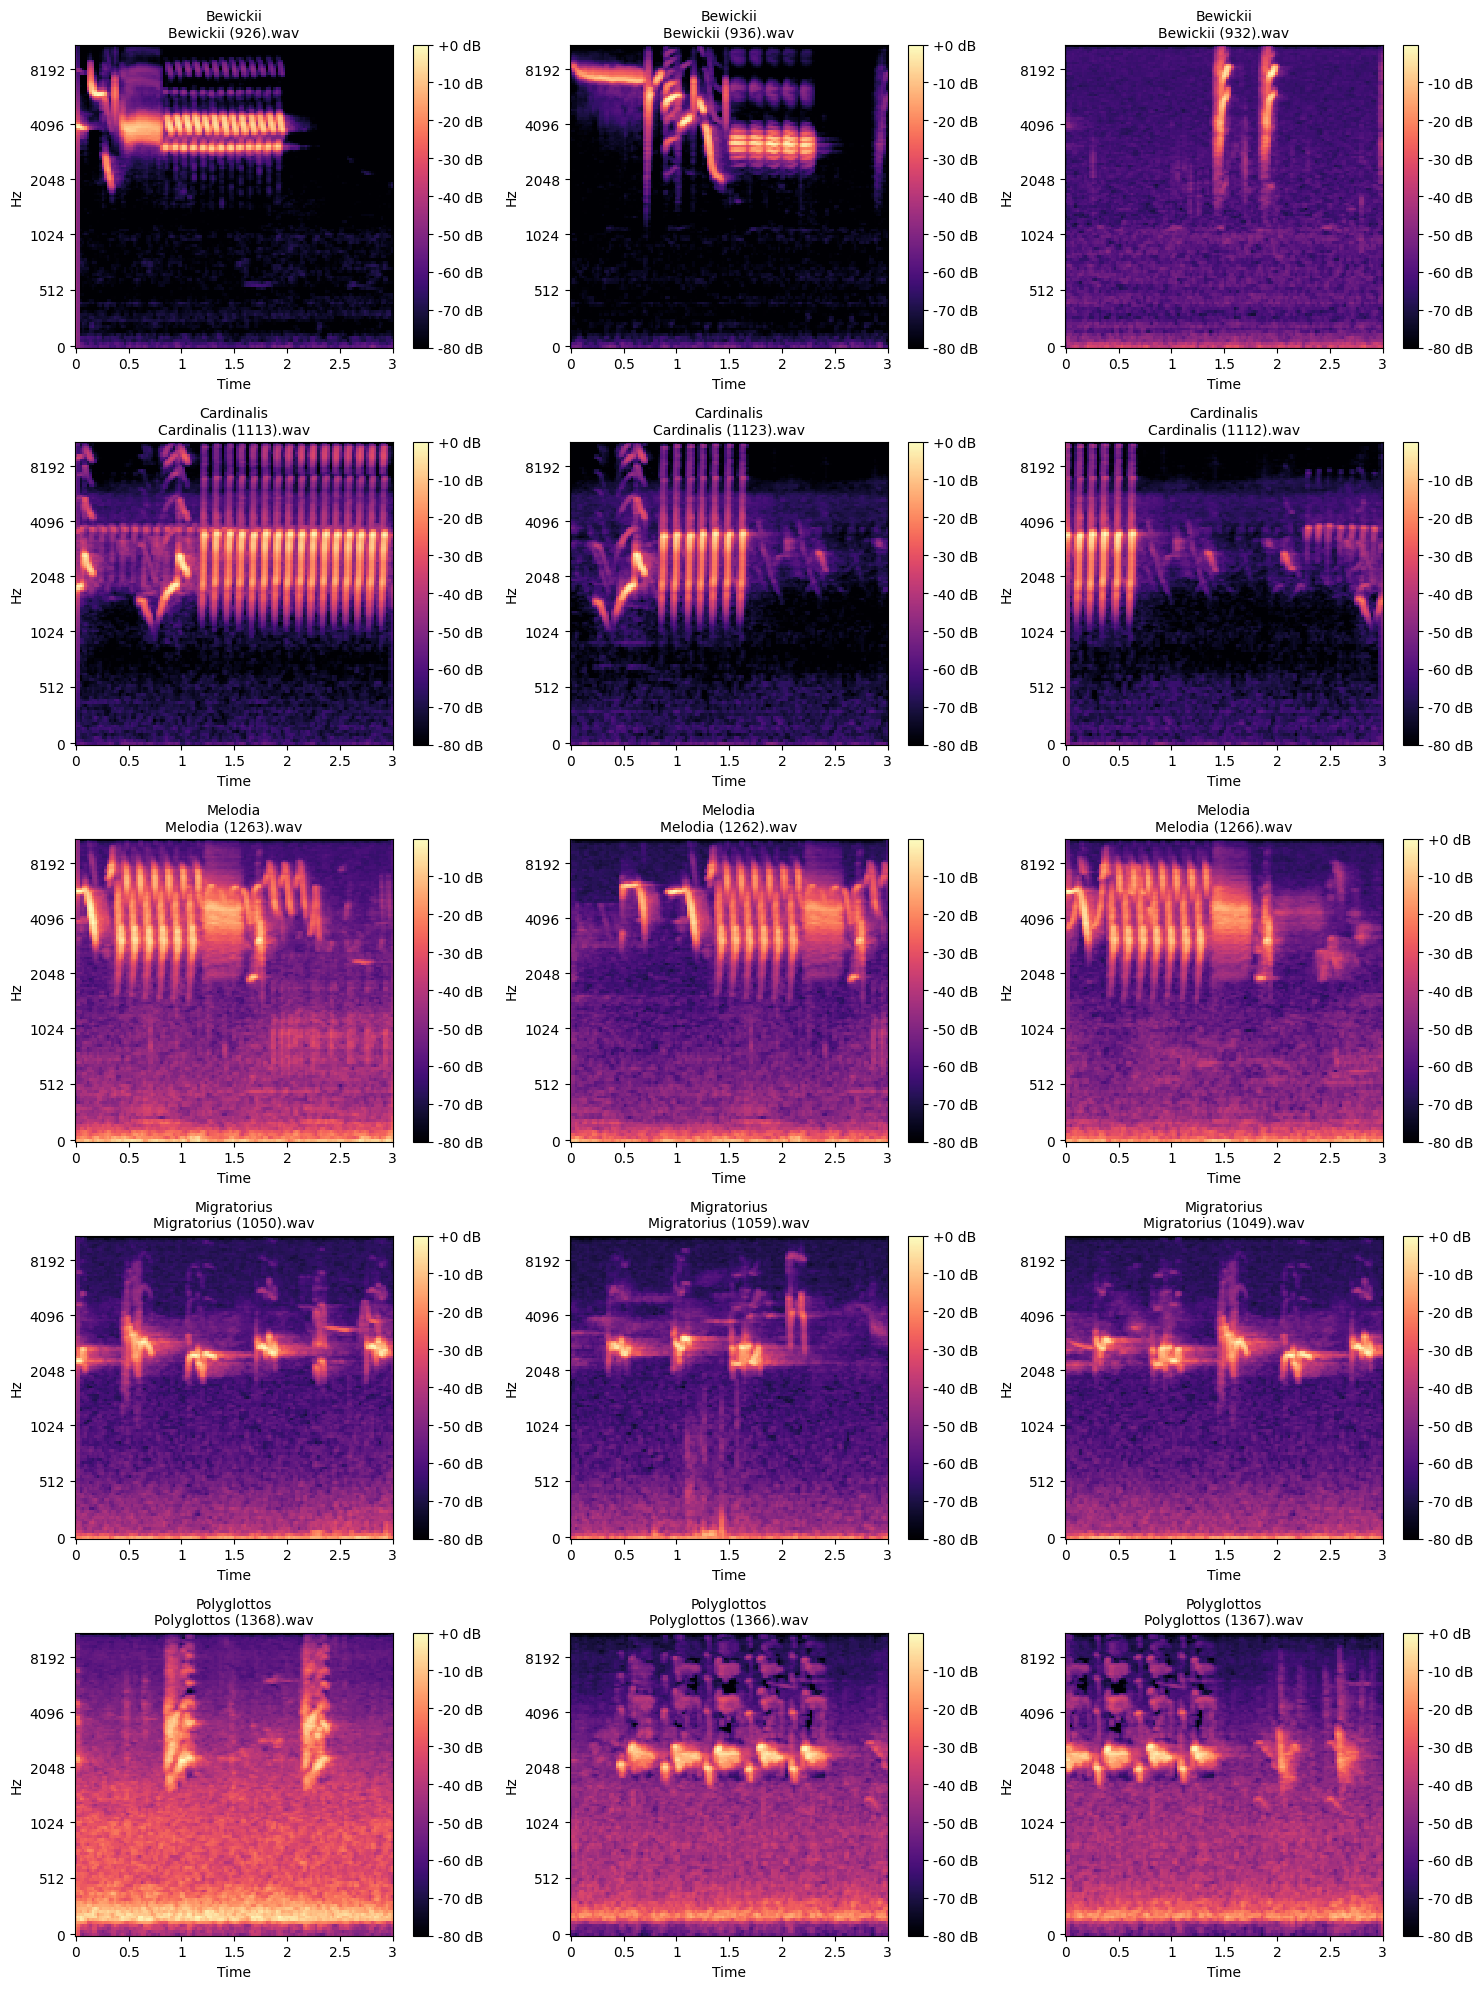

In [ ]:
# Função para extrair o espectrograma de um áudio
def extrair_espectrograma(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)  # Carregar o áudio e a taxa de amostragem
    espectrograma = librosa.feature.melspectrogram(y=audio, sr=sr)  # Calcular o espectrograma
    return espectrograma

# Caminho para a pasta principal que contém as pastas com os áudios de cada espécie
caminho_base = '/content/drive/MyDrive/passaros'

# Criar uma figura para visualizar os espectrogramas de todas as espécies
plt.figure(figsize=(15, 20))

# Loop através das pastas representando cada espécie
for i, pasta_especie in enumerate(os.listdir(caminho_base)):
    caminho_pasta_especie = os.path.join(caminho_base, pasta_especie)
    if not os.path.isdir(caminho_pasta_especie):
        continue

    # Escolha alguns áudios da espécie atual para visualizar (vamos escolher 3)
    num_audios_para_visualizar = 3
    audios_para_visualizar = os.listdir(caminho_pasta_especie)[:num_audios_para_visualizar]

    # Loop através dos áudios escolhidos para visualização
    for j, nome_arquivo in enumerate(audios_para_visualizar):
        caminho_audio = os.path.join(caminho_pasta_especie, nome_arquivo)

        # Extrair o espectrograma do áudio
        espectrograma = extrair_espectrograma(caminho_audio)

        # Plotar o espectrograma na figura
        plt.subplot(len(os.listdir(caminho_base)), num_audios_para_visualizar, i*num_audios_para_visualizar + j + 1)
        librosa.display.specshow(librosa.power_to_db(espectrograma, ref=np.max),
                                 y_axis='mel', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'{pasta_especie}\n{nome_arquivo}', fontsize=10)

# Ajustar os espaçamentos e mostrar a figura com os espectrogramas de todas as espécies
plt.tight_layout()
plt.show()


## Gerando os MFCCs com base no áudio do canto dos pássaros.
### Também aplicado o standarscale e o T-SNE para pré-processamento

In [ ]:
# Caminho para a pasta principal que contém as pastas com os áudios de cada espécie
caminho_base = '/content/drive/MyDrive/passaros'

# Lista para armazenar os dados das colunas do dataset
dados_colunas = {}

# Função para extrair os MFCCs de um áudio e aplicar o StandardScaler
def extrair_mfcc_com_tsne(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)  # Carregar o áudio e a taxa de amostragem
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # Extrair os MFCCs

    # Aplicar o StandardScaler aos MFCCs
    scaler = StandardScaler()
    mfccs_scaled = scaler.fit_transform(mfccs)

    # Aplicar o t-SNE para redução de dimensionalidade
    tsne = TSNE(n_components=2, perplexity=7, random_state=42)
    mfccs_tsne = tsne.fit_transform(mfccs_scaled)

    return mfccs_tsne

# Loop através das pastas representando cada espécie
for pasta_especie in os.listdir(caminho_base):
    caminho_pasta_especie = os.path.join(caminho_base, pasta_especie)
    if not os.path.isdir(caminho_pasta_especie):
        continue

    # Lista para armazenar os MFCCs de cada áudio da espécie atual
    mfccs_especie_atual = []

    # Loop através dos áudios de cada espécie
    for nome_arquivo in os.listdir(caminho_pasta_especie):
        caminho_audio = os.path.join(caminho_pasta_especie, nome_arquivo)

        # Verificar se o caminho aponta para um arquivo de áudio
        if not os.path.isfile(caminho_audio):
            continue

        # Extrair os MFCCs com StandardScaler e t-SNE
        mfccs_tsne = extrair_mfcc_com_tsne(caminho_audio)
        mfccs_especie_atual.append(mfccs_tsne)

    # Converter a lista de MFCCs em um DataFrame e adicionar ao dicionário
    dados_colunas[pasta_especie] = pd.Series(mfccs_especie_atual)

# Criar o DataFrame a partir do dicionário
df_a = pd.DataFrame(dados_colunas)
df_a.fillna(0, inplace=True)

In [ ]:
df_a

,Bewickii,Cardinalis,Melodia,Migratorius,Polyglottos
0,"[[-69.77557, -119.0601], [-45.875553, -104.078...","[[-42.74475, 12.634037], [-27.551922, -12.1097...","[[-10.785381, 16.193474], [-18.890892, -22.224...","[[120.97992, -55.49775], [-52.21478, 62.866695...","[[13.801068, 44.728436], [-4.412438, -41.81559..."
1,"[[-1.2732812, -67.35555], [-10.419226, -44.077...","[[-91.30563, -15.395273], [-52.196766, 34.4913...","[[11.876309, -84.87522], [-29.492168, -33.4271...","[[133.4989, -61.64966], [-64.715256, 7.2682214...","[[-4.7966275, 15.032937], [4.375243, 28.31396]..."
2,"[[-53.90786, 145.0169], [76.00615, 115.6687], ...","[[76.09831, 22.780264], [50.774277, -34.109985...","[[-80.08743, 66.63977], [-98.62199, -25.831068...","[[-23.11232, 124.49892], [1.8810045, -84.23096...","[[-33.126026, -5.3087115], [16.504436, -5.4394..."
3,"[[186.05888, -18.775396], [121.78573, -26.8837...","[[14.028675, -0.6707214], [6.2412233, -8.96888...","[[62.07454, -31.706951], [-66.92317, 44.505074...","[[-72.35926, 103.222], [38.096043, -72.08732],...","[[54.2962, 75.01541], [-57.62614, -82.880325],..."
4,"[[19.618933, 108.30013], [32.230156, 73.80346]...","[[77.88173, -29.33096], [51.215755, -7.379092]...","[[-4.4094462, 137.57079], [137.25465, -83.4159...","[[66.08259, -71.2695], [-90.97888, -19.64902],...","[[207.7428, 23.559149], [-166.99448, 92.51735]..."
...,...,...,...,...,...
995,"[[-106.49392, -45.958996], [-67.72043, 29.4406...","[[-103.98565, 6.6269636], [119.835075, -19.089...","[[-27.327082, -82.78648], [-23.975851, 115.233...","[[-58.728027, -130.24892], [28.115263, 80.7379...","[[0.523935, 107.05879], [-43.044003, -10.19541..."
996,"[[-22.61686, 16.090548], [-3.0063887, -0.13965...","[[74.87266, -1.1918557], [-102.045395, -58.061...","[[131.38237, -7.4883566], [-124.35979, -44.521...","[[-142.07318, 8.221516], [96.44024, 32.713413]...","[[-121.847946, 17.977016], [5.3281503, -10.589..."
997,"[[-137.73784, 31.648859], [97.71256, -55.95633...","[[137.91806, -118.55537], [-44.259502, 100.377...","[[-10.719669, -29.200468], [-9.003285, 46.0931...","[[-131.49751, 204.68083], [101.871994, -167.15...","[[36.395008, -117.55359], [24.0923, 18.197086]..."
998,"[[-15.336679, -8.371008], [-2.1606255, 1.25747...","[[-53.29497, 81.62551], [-20.334692, 8.705214]...","[[295.1478, 21.632568], [-340.10965, 70.07978]...","[[148.0064, 46.95567], [-126.625206, -5.639621...","[[-94.235664, -131.44699], [38.8521, 32.43895]..."


## Spectral centroids

In [ ]:
# Lista para armazenar os dados das colunas do dataset dos valores do Spectral Centroid
dados_colunas_spectral_centroid = {}

# Função para extrair o Spectral Centroid de um áudio (usando MFCCs sintéticos)
def extrair_spectral_centroid(mfcc_row):
    y = librosa.feature.inverse.mfcc_to_audio(mfcc_row)
    spectral_centroid = librosa.feature.spectral_centroid(y=y)
    return spectral_centroid[0][0]

# Loop através das colunas representando cada espécie (MFCCs)
for species in df_a.columns:
    for mfcc_row in df_a[species]:
        spectral_centroid = extrair_spectral_centroid(mfcc_row)
        if species not in dados_colunas_spectral_centroid:
            dados_colunas_spectral_centroid[species] = []
        dados_colunas_spectral_centroid[species].append(spectral_centroid)

# Criar o DataFrame a partir do dicionário
df_spectral_centroid = pd.DataFrame(dados_colunas_spectral_centroid)

# Aplicar o StandardScaler
scaler = StandardScaler()
df_spectral_centroid_scaled = scaler.fit_transform(df_spectral_centroid)

# Aplicar o t-SNE
tsne = TSNE(n_components=2, perplexity=7)   # Defina o número de componentes conforme necessário
df_spectral_centroid_tsne = tsne.fit_transform(df_spectral_centroid_scaled)

# df_spectral_centroid_tsne agora contém as coordenadas t-SNE dos dados


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


In [ ]:
df_spectral_centroid_tsne

array([[-49.259525 ,  24.259285 ],
       [-35.766994 ,  25.417393 ],
       [ 36.959286 ,  24.714115 ],
       ...,
       [  1.2279295,  11.700172 ],
       [ 26.010698 ,  46.942814 ],
       [ 22.491741 ,  42.904327 ]], dtype=float32)

## Processo de Clusterização

In [ ]:
# Carregar o DataFrame (supondo que os dados já estão padronizados)
data_series = df_a.stack()

# Converter a série em uma matriz 2D
data_2d = np.vstack(data_series.values)

# Obter os nomes das espécies
nomes_especies = [i[1] for i in data_series.index.tolist()]

# Escolher o número de clusters (9, conforme você mencionou)
n_clusters = 5

# Aplicar o K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data_2d)

# Obter as etiquetas de cluster atribuídas pelo K-Means
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


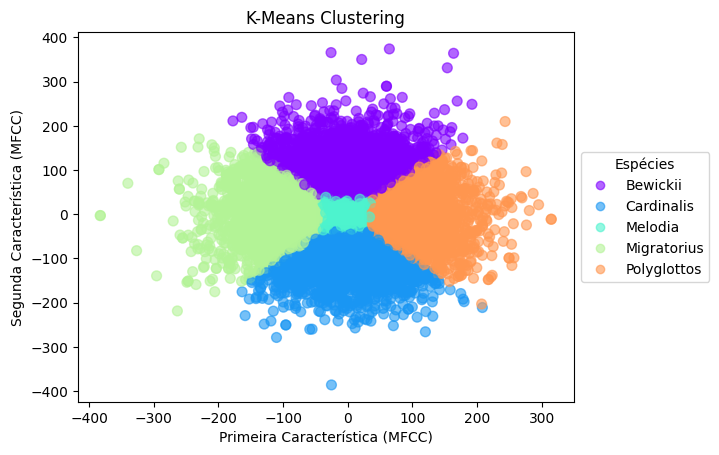

In [ ]:
# Criar uma paleta de cores com base nos clusters
cmap = mcolors.ListedColormap([plt.cm.rainbow(i / n_clusters) for i in range(n_clusters)])

# Plotar os dados com cores de acordo com o cluster atribuído
scatter_points = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_labels, cmap=cmap, s=50, alpha=0.6)

# Criar uma legenda com os nomes das espécies na tabela lateral
handles, labels = scatter_points.legend_elements()
legend = plt.legend(handles, nomes_especies, loc='center left', bbox_to_anchor=(1, 0.5), title='Espécies')

# Adicionar os nomes das espécies como labels à tabela lateral
for label, especie in zip(legend.get_texts(), nomes_especies):
    label.set_text(especie)

plt.xlabel('Primeira Característica (MFCC)')
plt.ylabel('Segunda Característica (MFCC)')
plt.title('K-Means Clustering')
plt.show()


## Métricas para validar confiabilidade

In [ ]:
# Inicializar o algoritmo K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_series = df_a.stack()

# Converter a série em uma matriz 2D
data_2d = np.vstack(data_series.values)

# Ajustar o modelo K-Means e obter os rótulos dos clusters
cluster_labels = kmeans.fit_predict(data_2d)

# Obter as etiquetas de cluster atribuídas pelo K-Means
cluster_labels = kmeans.labels_

# Calcular o Silhouette Score
silhouette = silhouette_score(data_2d, cluster_labels)
print(f'Silhouette Score: {silhouette}')

# Calcular o Calinski-Harabasz Score
calinski_harabasz = calinski_harabasz_score(data_2d, cluster_labels)
print(f'Calinski-Harabasz Score: {calinski_harabasz}')

# Calcular o Davies-Bouldin Score
davies_bouldin = davies_bouldin_score(data_2d, cluster_labels)
print(f'Davies-Bouldin Score: {davies_bouldin}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.3306505084037781
Calinski-Harabasz Score: 28848.411439419913
Davies-Bouldin Score: 0.9053319703224206


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Fazer previsões nos dados de teste
y_pred_mfcc = model_mfcc.predict(X_test_mfcc)
y_pred_classes_mfcc = np.argmax(y_pred_mfcc, axis=1)

# Calcular as métricas
accuracy_mfcc = accuracy_score(y_test_mfcc, y_pred_classes_mfcc)
precision_mfcc = precision_score(y_test_mfcc, y_pred_classes_mfcc, average='weighted')
recall_mfcc = recall_score(y_test_mfcc, y_pred_classes_mfcc, average='weighted')
f1_mfcc = f1_score(y_test_mfcc, y_pred_classes_mfcc, average='weighted')

print("Accuracy (MFCC):", accuracy_mfcc)
print("Precision (MFCC):", precision_mfcc)
print("Recall (MFCC):", recall_mfcc)
print("F1-score (MFCC):", f1_mfcc)

# Artigo 2
##### Usando Técnica CNN

### Preparando os Dados para o uso de CNN

In [ ]:
# Função para geração dos espectogramas
def carregar_espectrogramas(caminho_base, tamanho_img):
    espectrogramas = []
    labels = []

    # Loop através das pastas representando cada espécie
    for i, pasta_especie in enumerate(os.listdir(caminho_base)):
        caminho_pasta_especie = os.path.join(caminho_base, pasta_especie)
        if not os.path.isdir(caminho_pasta_especie):
            continue

        # Loop através dos áudios da espécie
        for nome_arquivo in os.listdir(caminho_pasta_especie):
            caminho_audio = os.path.join(caminho_pasta_especie, nome_arquivo)

            # Extrair o espectrograma do áudio
            espectrograma = extrair_espectrograma(caminho_audio)

            # Redimensionar o espectrograma para o tamanho desejado
            espectrograma = cv2.resize(espectrograma, (tamanho_img, tamanho_img))

            # Aplicar aumento de dados nos espectrogramas
            data_generator = ImageDataGenerator(rotation_range=10, zoom_range=0.1)
            especie_label = i  # Usar o índice como label da espécie

            # Adicionar o espectrograma e o label às listas
            espectrogramas.append(espectrograma)
            labels.append(especie_label)

    # Converter as listas em arrays numpy
    espectrogramas = np.array(espectrogramas)
    labels = np.array(labels)

    return espectrogramas, labels

In [ ]:
# Caminho para a pasta principal que contém as pastas com os áudios de cada espécie
caminho_base = '/content/drive/MyDrive/passaros'

# Tamanho desejado para os espectrogramas (exemplo: 128x128)
tamanho_espectrograma = 128

# Carregar os espectrogramas e os labels correspondentes com aumento de dados
espectrogramas, labels = carregar_espectrogramas(caminho_base, tamanho_espectrograma)

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(espectrogramas, labels, test_size=0.2, random_state=42)

# Normalizar os dados dividindo pelo valor máximo dos espectrogramas
X_train = X_train / 255.0
X_test = X_test / 255.0

Código para criar imagem com a arquiterura.

In [ ]:
!pip install pydot
!pip install graphviz

In [ ]:
!sudo apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
from keras.utils import plot_model
import matplotlib.pyplot as plt

# Criar o modelo CNN
model = Sequential()

# Adicionar camadas convolucionais e de pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(tamanho_espectrograma, tamanho_espectrograma, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattening para conectar às camadas densas
model.add(Flatten())

# Adicionar camadas densas e dropout para regularização
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(9, activation='softmax'))  # 9 classes para as 9 espécies de aves

# Compilar o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Exibir a arquitetura da CNN na tela
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plt.show()


Código original com a exibição do treinamento

In [ ]:
# Criar o modelo CNN
model = Sequential()

# Adicionar camadas convolucionais e de pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(tamanho_espectrograma, tamanho_espectrograma, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattening para conectar às camadas densas
model.add(Flatten())

# Adicionar camadas densas e dropout para regularização
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(9, activation='softmax'))  # 9 classes para as 9 espécies de aves

# Compilar o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Exibir a arquitetura da CNN
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)     

In [ ]:
# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Avaliação do modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Acurácia no conjunto de teste: {test_acc}')

Epoch 1/10
125/125 [==============================] - 202s 2s/step - loss: 1.1868 - accuracy: 0.4950 - val_loss: 0.8650 - val_accuracy: 0.6370
Epoch 2/10
125/125 [==============================] - 193s 2s/step - loss: 0.7844 - accuracy: 0.6900 - val_loss: 0.6657 - val_accuracy: 0.7560
Epoch 3/10
125/125 [==============================] - 176s 1s/step - loss: 0.6320 - accuracy: 0.7685 - val_loss: 0.6174 - val_accuracy: 0.7740
Epoch 4/10
125/125 [==============================] - 177s 1s/step - loss: 0.4684 - accuracy: 0.8255 - val_loss: 0.5740 - val_accuracy: 0.7770
Epoch 5/10
125/125 [==============================] - 184s 1s/step - loss: 0.3478 - accuracy: 0.8770 - val_loss: 0.5613 - val_accuracy: 0.7970
Epoch 6/10
125/125 [==============================] - 188s 2s/step - loss: 0.2812 - accuracy: 0.8982 - val_loss: 0.6985 - val_accuracy: 0.7750
Epoch 7/10
125/125 [==============================] - 188s 2s/step - loss: 0.2052 - accuracy: 0.9233 - val_loss: 0.6198 - val_accuracy: 0.8140

Gráfico de lollipop para melhor exibição

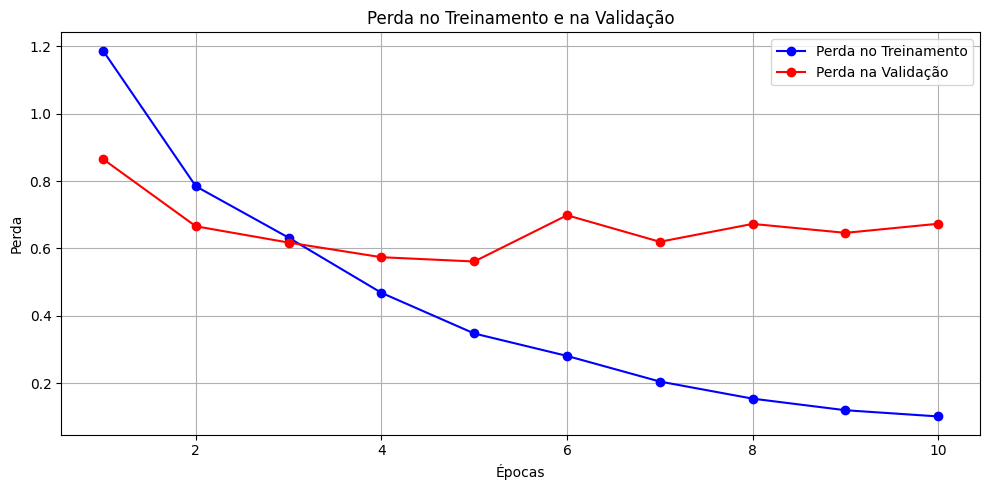

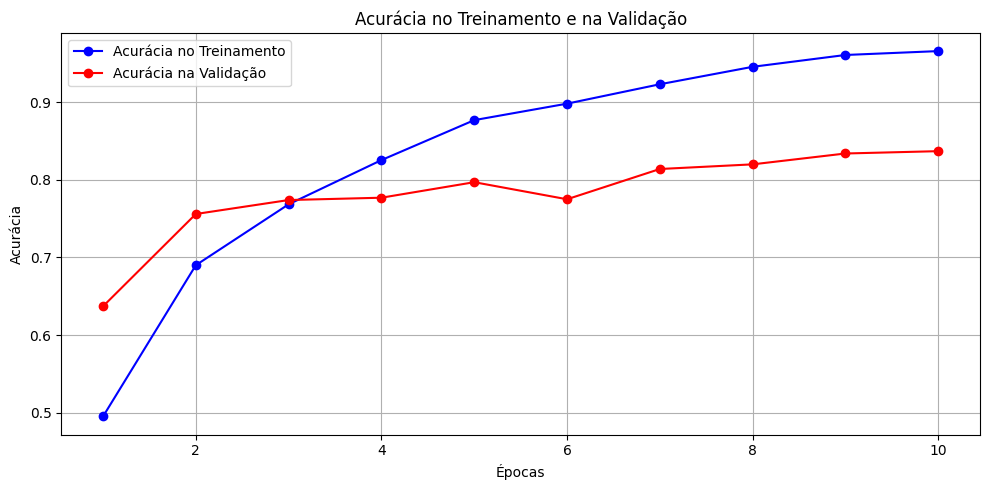

In [ ]:
import matplotlib.pyplot as plt

# Extrair a perda e a acurácia do histórico de treinamento
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plotar a perda
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Perda no Treinamento', marker='o')
plt.plot(epochs, val_loss, 'r', label='Perda na Validação', marker='o')
plt.title('Perda no Treinamento e na Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotar a acurácia
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'b', label='Acurácia no Treinamento', marker='o')
plt.plot(epochs, val_acc, 'r', label='Acurácia na Validação', marker='o')
plt.title('Acurácia no Treinamento e na Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


32/32 [==============================] - 11s 325ms/step


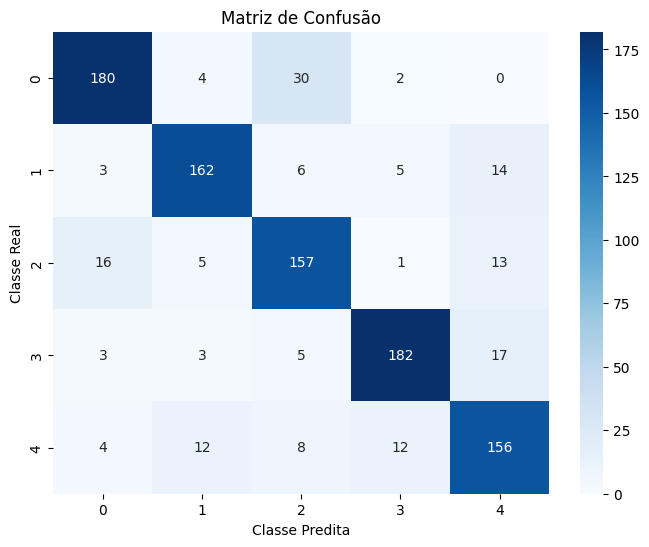

<Figure size 1000x600 with 0 Axes>

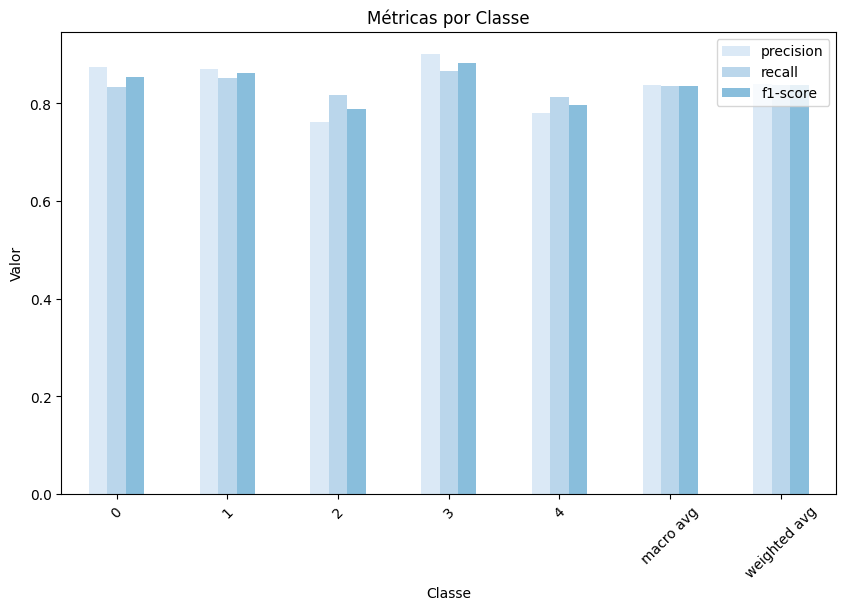

In [ ]:
# Obter as previsões de probabilidade do modelo para os dados de teste
y_probs = model.predict(X_test)

# Converter as probabilidades em classes preditas
y_pred = np.argmax(y_probs, axis=1)

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão como um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

# Calcular o relatório de classificação
classif_report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(classif_report).transpose()

# Excluir a última linha do dataframe que contém a média das métricas
report_df.drop('accuracy', inplace=True)

# Plotar métricas para cada classe (precisão, recall, f1-score)
sns.set_palette("Blues")
plt.figure(figsize=(10, 6))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Métricas por Classe')
plt.xlabel('Classe')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Converter as previsões em classes preditas
y_pred = np.argmax(y_probs, axis=1)

# Obter o classification report
classif_report = classification_report(y_test, y_pred, output_dict=True)

# Converter o relatório para um dataframe do pandas para facilitar a análise
report_df = pd.DataFrame(classif_report).transpose()

print(report_df)  # Imprime o relatório em formato tabular

              precision    recall  f1-score   support
0              0.873786  0.833333  0.853081   216.000
1              0.870968  0.852632  0.861702   190.000
2              0.762136  0.817708  0.788945   192.000
3              0.900990  0.866667  0.883495   210.000
4              0.780000  0.812500  0.795918   192.000
accuracy       0.837000  0.837000  0.837000     0.837
macro avg      0.837576  0.836568  0.836628  1000.000
weighted avg   0.839520  0.837000  0.837817  1000.000


# Artigo 3
##### Coeficientes Cefalocaudais de Mel Frequência (WMFCCs)

### Preparando os Dados para o uso de WMFCCs

codigo abaixo é teste

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import zscore
from sklearn.manifold import TSNE
from python_speech_features import logfbank, delta
from sklearn.preprocessing import StandardScaler

# Caminho para a pasta principal que contém as pastas com os áudios de cada espécie
caminho_base = '/content/drive/MyDrive/passaros'

# Lista para armazenar os dados das colunas do dataset
dados_colunas = {}

# Função para extrair os WMFCCs de um áudio e aplicar o StandardScaler
def extrair_wmfcc_com_tsne(audio_path):
    print("Processando áudio:", audio_path)
    audio, sr = librosa.load(audio_path, sr=None)  # Carregar o áudio e a taxa de amostragem

    # Ajustar o tamanho do quadro para evitar o truncamento
    frame_length = 25  # 25ms é uma escolha comum para o tamanho do quadro
    hop_length = 10  # Sobreposição de 10ms

    # Ajustar o tamanho da FFT para ser igual a 551
    n_fft = 551

    log_mel = logfbank(audio, samplerate=sr, nfilt=40, winlen=frame_length / 1000, winstep=hop_length / 1000, nfft=n_fft)

    # Aplicar o StandardScaler aos log-filtros de Mel
    scaler = StandardScaler()
    log_mel_scaled = scaler.fit_transform(log_mel)

    # Calcular as derivadas (delta) dos log-filtros de Mel
    delta_log_mel = delta(log_mel_scaled, N=2)

    # Concatenar os log-filtros de Mel e suas derivadas
    wmfccs = np.concatenate((log_mel_scaled, delta_log_mel), axis=1)

    # Normalizar os WMFCCs
    wmfccs = (wmfccs - np.mean(wmfccs, axis=0)) / np.std(wmfccs, axis=0)

    # Aplicar o t-SNE para redução de dimensionalidade
    tsne = TSNE(n_components=2, perplexity=7, random_state=42)
    wmfccs_tsne = tsne.fit_transform(wmfccs)

    return wmfccs_tsne

# Função para processar uma espécie
def processar_especie(pasta_especie, executor):
    wmfccs_especie_atual = []
    print("Processando espécie:", pasta_especie)

    caminho_pasta_especie = os.path.join(caminho_base, pasta_especie)
    audio_paths = [os.path.join(caminho_pasta_especie, nome_arquivo) for nome_arquivo in os.listdir(caminho_pasta_especie) if os.path.isfile(os.path.join(caminho_pasta_especie, nome_arquivo))]

    # Barra de progresso simples
    total_audios = len(audio_paths)
    futures = []

    for i, audio_path in enumerate(audio_paths, 1):
        print(f"Processando áudio {i}/{total_audios}", end='\r')
        future = executor.submit(extrair_wmfcc_com_tsne, audio_path)
        futures.append(future)

    # Aguardar a conclusão de todas as tarefas
    for future in futures:
        wmfccs_tsne = future.result()
        if wmfccs_tsne is not None:
            wmfccs_especie_atual.append(wmfccs_tsne)

    dados_colunas[pasta_especie] = pd.Series(wmfccs_especie_atual)
    print()  # Para pular uma linha após a barra de progresso

# Iniciar processamento
print("Iniciando processamento...")

# Listar todas as espécies antes de iniciar o processamento em paralelo
pastas_especies = [pasta for pasta in os.listdir(caminho_base) if os.path.isdir(os.path.join(caminho_base, pasta))]

# Processar cada espécie em paralelo usando ThreadPoolExecutor com 5 workers
with ThreadPoolExecutor(max_workers=5) as executor:
    for pasta_especie in pastas_especies:
        processar_especie(pasta_especie, executor)

# Criar o DataFrame a partir do dicionário
df_wmfccs = pd.DataFrame(dados_colunas)
df_wmfccs.fillna(0, inplace=True)

# Imprimir o número total de áudios processados ao final
print("Número total de áudios processados:", sum(len(wmfccs) for wmfccs in dados_colunas.values()))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


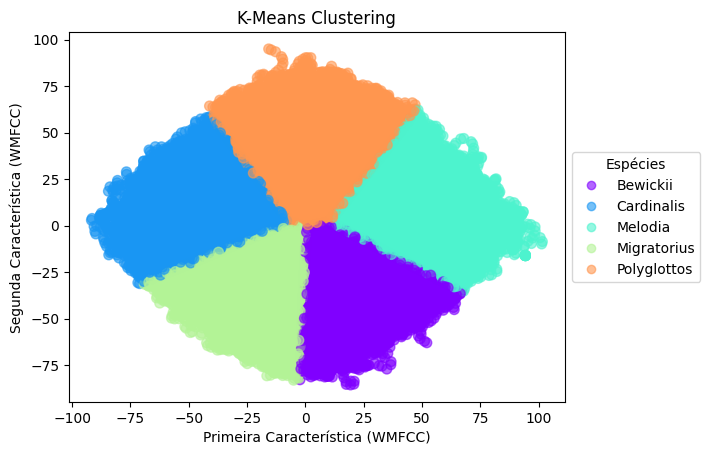

In [ ]:
# Carregar o DataFrame (supondo que os dados já estão padronizados)
data_series = df_wmfccs.stack()

# Converter a série em uma matriz 2D
data_2d = np.vstack(data_series.values)

# Obter os nomes das espécies
nomes_especies = [i[1] for i in data_series.index.tolist()]

# Escolher o número de clusters (9, conforme mencionado)
n_clusters = 5

# Aplicar o K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data_2d)

# Obter as etiquetas de cluster atribuídas pelo K-Means
cluster_labels = kmeans.labels_

# Criar uma paleta de cores com base nos clusters
cmap = mcolors.ListedColormap([plt.cm.rainbow(i / n_clusters) for i in range(n_clusters)])

# Plotar os dados com cores de acordo com o cluster atribuído
scatter_points = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_labels, cmap=cmap, s=50, alpha=0.6)

# Criar uma legenda com os nomes das espécies na tabela lateral
handles, labels = scatter_points.legend_elements()
legend = plt.legend(handles, nomes_especies, loc='center left', bbox_to_anchor=(1, 0.5), title='Espécies')

# Adicionar os nomes das espécies como labels à tabela lateral
for label, especie in zip(legend.get_texts(), nomes_especies):
    label.set_text(especie)

plt.xlabel('Primeira Característica (WMFCC)')
plt.ylabel('Segunda Característica (WMFCC)')
plt.title('K-Means Clustering')
plt.show()


## Métricas para validar confiabilidade

In [ ]:
# Calcular o Silhouette Score
silhouette = silhouette_score(data_2d, cluster_labels)
print(f'Silhouette Score: {silhouette}')

In [ ]:

# Calcular o Calinski-Harabasz Score
calinski_harabasz = calinski_harabasz_score(data_2d, cluster_labels)
print(f'Calinski-Harabasz Score: {calinski_harabasz}')

# Calcular o Davies-Bouldin Score
davies_bouldin = davies_bouldin_score(data_2d, cluster_labels)
print(f'Davies-Bouldin Score: {davies_bouldin}')

Calinski-Harabasz Score: 1187594.002557503
Davies-Bouldin Score: 0.8937626091660924
